In [108]:
import json
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

# Loading Data & Pre-processing

In [20]:
text = ''
with open('Cell_Phones_and_Accessories_5.json', 'r') as file:
    text = file.read()

In [32]:
new_text = text.replace('\n', ',\n')
new_text = new_text.strip(',\n')
new_text = f'[{new_text}]'
parsed_text = json.loads(new_text)
parsed_text[0]

{'reviewerID': 'A30TL5EWN6DFXT',
 'asin': '120401325X',
 'reviewerName': 'christina',
 'helpful': [0, 0],
 'reviewText': "They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again",
 'overall': 4.0,
 'summary': 'Looks Good',
 'unixReviewTime': 1400630400,
 'reviewTime': '05 21, 2014'}

In [64]:
X = []
y = []

for item in parsed_text:
    X.append(item['reviewText'])
    y.append(1 if item['overall'] > 3 else 0)

len(X), len(y)

(194439, 194439)

In [65]:
tokenizer = Tokenizer(oov_token= 'OOV')

tokenizer.fit_on_texts(X)
len(tokenizer.word_index)

92128

In [66]:
# Finding max sequence langth
lengths = [len(sequence.split(' ')) for sequence in X]
avg_length = sum(lengths) / len(lengths)
avg_length

92.99432212673383

In [67]:
X = tokenizer.texts_to_sequences(X)
max_length = 200
X = pad_sequences(X, padding= 'post', maxlen= max_length, truncating='post')

In [68]:
X[100]

array([42072,     4,   169,   117,    49,   242,    63,   113,  5959,
          25,    18,  1126,   892,     2,    85,    11,     4,     3,
         111,   113,    10,    79,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [95]:
y = np.array(y, dtype= np.int32)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.9, shuffle= True)

In [96]:
X_train.shape, y_train.shape

((174995, 200), (174995, 1))

# Creating and Training Model

In [97]:
num_labels = len(tokenizer.word_index)
epochs = 20

In [117]:
model = Sequential([
    Embedding(num_labels, 100, input_length= max_length),
    Bidirectional(LSTM(128)),
    Dropout(0.4),
    Dense(units= 1, activation= 'sigmoid')
])

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 100)          9212800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 9,447,553
Trainable params: 9,447,553
Non-trainable params: 0
_________________________________________________________________


In [118]:
checkpoint = ModelCheckpoint(filepath= 'model.h5', monitor='val_loss', save_best_only= True, save_weights_only=False, mode= 'min', save_freq='epoch', verbose=1)
earlyStopping = EarlyStopping(monitor='val_loss', mode= 'min', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs= epochs, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint, earlyStopping])

Epoch 1/20
2735/2735 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8453
Epoch 1: val_loss improved from inf to 0.30632, saving model to model.h5
2735/2735 [==============================] - 293s 105ms/step - loss: 0.3605 - accuracy: 0.8453 - val_loss: 0.3063 - val_accuracy: 0.8701
Epoch 2/20
2735/2735 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8878
Epoch 2: val_loss improved from 0.30632 to 0.28353, saving model to model.h5
2735/2735 [==============================] - 455s 166ms/step - loss: 0.2767 - accuracy: 0.8878 - val_loss: 0.2835 - val_accuracy: 0.8793
Epoch 3/20
2735/2735 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9068
Epoch 3: val_loss did not improve from 0.28353
2735/2735 [==============================] - 561s 205ms/step - loss: 0.2331 - accuracy: 0.9068 - val_loss: 0.2934 - val_accuracy: 0.8808
Epoch 4/20
2735/2735 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9223


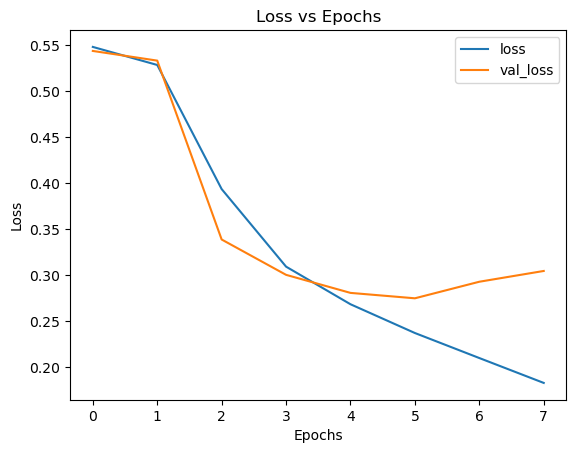

In [115]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['loss', 'val_loss'])

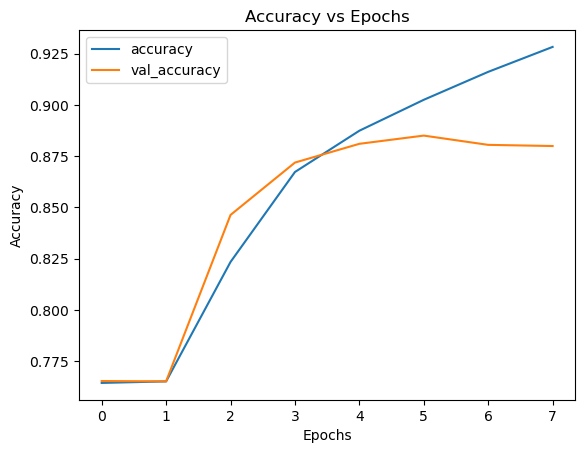

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['accuracy', 'val_accuracy'])